## Generating two dimensional cluster states

In this notebook we generate two dimensional, 3 by n grid, cluster states with the sequential emission protocol

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sps

import cirq
from qutip import *

import qutrit_utils
import graph_state_gen_circuits as gsg

In [3]:
### system parameters
qus = [3,6,9]

waittimes = [0.125, 0.2, 0.125, 0.125, 0.075, 0.205, 0.275, 0.205]
coherence_times1 = [27, 22, 16, 12]
coherence_times2 = [22, 23, 4, 6]
coherence_times3 = [27, 22, 16, 12]

nparams = [0.0, 0.02, 0.01, 0.0]

In [4]:
##-- initialize the simulators
simulator = cirq.Simulator()
dsim = cirq.DensityMatrixSimulator()

In [5]:
gsg.leak_cluster_state_2D_3S(3, 0.0, 0.0, 0.0)

┌────────┐   ┌──┐
0 (d=3): ───[H]───[Q3_CZ]───────────X───────────
                  │                 │
1 (d=3): ───[H]───@──────────[Q3_CZ]┼─────X─────
                             │      │     │
2 (d=3): ───[H]──────────────@──────┼─────┼X────
                                    │     ││
3: ─────────────────────────────────X─────┼┼────
                                          ││
4: ───────────────────────────────────────X┼────
                                           │
5: ────────────────────────────────────────X────
                            └────────┘   └──┘

In [6]:
gsg.noisy_cluster_state_2D_3S(3, waittimes, coherence_times1, coherence_times2, coherence_times3, nparams)

┌────────┐   ┌────────┐
0 (d=3): ───[Q3_AD]───[Q3_PD]───[H]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_CZ]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]────X────────────[Q3_AD]─────[Q3_PD]─────────────
                                                                              │                                                                                          │
1 (d=3): ───[Q3_AD]───[Q3_PD]───[H]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───@─────────[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_CZ]───[Q3_AD]───[Q3_PD]───[Q3_AD]────┼[Q3_PD]─────X───────────[Q3_AD]───[Q3_PD]───
                                                                                                                                │                                        │            │
2 (d=3): ───[Q3_AD]───[Q3_PD]───[H]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]───[Q3_AD]───[Q3_PD]─────────────@─────────[Q3_AD]───[Q3_PD]───[Q3_AD]────┼[Q3_PD]─────┼──────X────[Q3_AD]───[Q3_PD]───
                                                                                                                                                                         │            │      │
3: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X────────────┼──────┼────────────────────────
                                                                                                                                                                                      │      │
4: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X──────┼────────────────────────
                                                                                                                                                                                             │
5: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X────────────────────────
                                                                                                                                                                        └────────┘   └────────┘

## Generating the states

In [7]:
%%time
### the ideal states
noiseless_states = []

for qu in qus:
    #- run the circuit
    ideal_run = simulator.simulate(gsg.leak_cluster_state_2D_3S(qu,0,0,0))
    
    #- ideal state in csr form
    ideal_rho = sps.csr_matrix(np.outer(np.conj(ideal_run.final_state_vector), ideal_run.final_state_vector))
    
    #- ideal state as qutip object
    irho = Qobj(ideal_rho, dims = [[3,3,3] + [2]*qu, [3,3,3] + [2]*qu])
    
    #- reduced state of the qubit register (trace out the storages)
    irho_qubits = ptrace(irho, list(range(3, qu+3)))
    
    noiseless_states.append(irho_qubits)
    
    print("Computation for %d qubits, done -->>" % qu)
#

Computation for 3 qubits, done -->>
Computation for 6 qubits, done -->>
Computation for 9 qubits, done -->>
CPU times: user 2.31 s, sys: 652 ms, total: 2.96 s
Wall time: 3.16 s


In [8]:
%%time
### the decoherence limited states
deco_states = []

for qu in qus:
    #- run the circuit
    deco_run = dsim.simulate(gsg.noisy_cluster_state_2D_3S(qu, waittimes, coherence_times1, coherence_times2, coherence_times3, [0,0,0,0]))
    
    #- deco state in csr form
    deco_rho = sps.csr_matrix(deco_run.final_density_matrix)
    
    #- ideal state as qutip object
    drho = Qobj(deco_rho, dims = [[3,3,3] + [2]*qu, [3,3,3] + [2]*qu])
    
    #- reduced state of the qubit register (trace out the storages)
    drho_qubits = ptrace(drho, list(range(3, qu+3)))
    
    deco_states.append(drho_qubits)
    print("Computation for %d qubits, done -->>" % qu)
#

Computation for 3 qubits, done -->>
Computation for 6 qubits, done -->>
Computation for 9 qubits, done -->>
CPU times: user 1min 43s, sys: 1min 27s, total: 3min 11s
Wall time: 4min 16s


In [9]:
%%time
### the noisy states
noisy_states = []

for qu in qus:
    #- run the circuit
    noisy_run = dsim.simulate(gsg.noisy_cluster_state_2D_3S(qu, waittimes, coherence_times1, coherence_times2, coherence_times3, nparams))
    
    #- deco state in csr form
    noisy_rho = sps.csr_matrix(noisy_run.final_density_matrix)
    
    #- ideal state as qutip object
    nrho = Qobj(noisy_rho, dims = [[3,3,3] + [2]*qu, [3,3,3] + [2]*qu])
    
    #- reduced state of the qubit register (trace out the storages)
    nrho_qubits = ptrace(nrho, list(range(3, qu+3)))
    
    noisy_states.append(nrho_qubits)
    
    print("Computation for %d qubits, done -->>" % qu)
#

Computation for 3 qubits, done -->>
Computation for 6 qubits, done -->>
Computation for 9 qubits, done -->>
CPU times: user 1min 35s, sys: 1min 3s, total: 2min 38s
Wall time: 2min 51s


### Fidelities

In [10]:
fides_deco = []
fides_noisy = []

for qq in range(len(qus)):
    fdeco = fidelity(deco_states[qq], noiseless_states[qq])**2
    ndeco = fidelity(noisy_states[qq], noiseless_states[qq])**2
    
    fides_deco.append(fdeco)
    fides_noisy.append(ndeco)
    
    print(qus[qq], fdeco, ndeco)
#

3 0.9522241249216434 0.9194163055673851
6 0.8598934390099967 0.7509187904423855
9 0.7764243671305269 0.6154021839434876


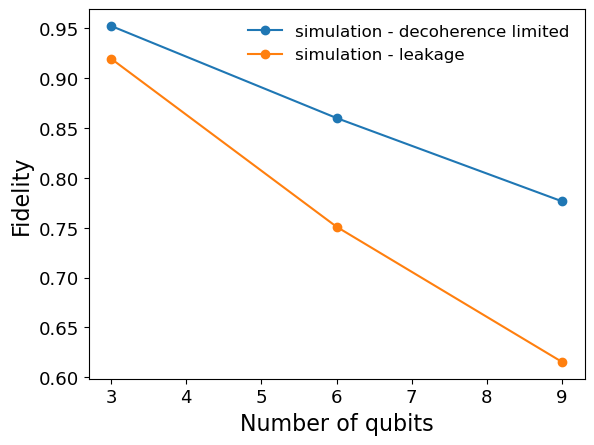

In [14]:
plt.plot(qus, fides_deco, "o-", label = "simulation - decoherence limited")
plt.plot(qus, fides_noisy, "o-", label = "simulation - leakage")

plt.legend(loc = "upper right", fontsize = 12, frameon = False)
plt.xlabel("Number of qubits", fontsize = 16)
plt.ylabel("Fidelity", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 13)
plt.show()

## Exporting the states

In [12]:
### path
#patho = "/Users/munm2002/Documents/projects/graph_states_for_ent_witness/data_states/cluster_state_2D/"

In [13]:
# ### save the states
# for ii in range(len(qus)):

#     qsave(noisy_states[ii], patho+"cluster_state_2D_%dqubits_3x%d.qu" % (qus[ii], int(qus[ii]/3)))

#     print("Size %d, completed -->>" % (qus[ii]))
# #